In [5]:
import numpy as np
import qiskit
import tqix
import sys, math
sys.path.insert(1, '../../')
import qsee.constant, 

In [196]:
n = 5

def calculate_TML(trial_state):
    ###################
    ## Calculate Pr
    ###################
    
    if (trial_state) is None:
        return -100
    trial_state = np.expand_dims(trial_state, 1)
    model = tqix.qmeas(trial_state, 'MUB')
    pr = model.probability()
    for i in range(0, len(pr)):
        if pr[i] == 0:
            pr[i] = 10**(-10)
    ###################
    ## Calculate fr
    ###################
    model = tqix.qmeas(state, 'MUB')
    cdf_model = tqix.qsim(model, niter = int(qsee.constant.num_shots / len(pr)), backend='cdf')
    fr = np.real(cdf_model.probability())
    ###################
    ## Calculate Tml
    ###################
    tml = 0
    for i in range(0, len(pr)):
        tml += np.real(fr[i]*np.log(pr[i]))
    return -tml


# state = tqix.random(4)
state = 2*np.random.rand(n)-1
state = state / np.linalg.norm(state)
state = np.expand_dims(state, axis = 0)
print(state)

[[ 0.35516921 -0.54565191 -0.2626922  -0.51739654  0.48929791]]


In [197]:
from math import cos, atan
import numpy as np
from scipy.optimize import minimize
from scipy import optimize
from scipy.optimize import NonlinearConstraint, Bounds
def constraint(x):
    """Normalize condition

    Args:
        x (np.narray): state vector psi

    Returns:
        float: norm of psi
    """
    norm = 0
    for i in x:
        norm += i**2
    return norm
def create_bound(n):
    bounds = []
    for i in range(0, n):
        bounds.append((-1, 1))
    return bounds

progress = []
progress_val = []

def cb(x, convergence):
    progress.append(x)
    progress_val.append(calculate_TML(x))

nlc = NonlinearConstraint(constraint, -1.0, 1.0)
results = optimize.differential_evolution(calculate_TML, create_bound(n), constraints=(nlc), callback=cb)

progress = np.array(progress)
progress_val = np.array(progress_val)


In [198]:
state1 = np.squeeze(state, axis = 0)
trace, fidelity = .get_metrics(state1, results.x)
print(trace)
print(fidelity)
print(state1)
print(results.x)

8.36432644083154e-09
(0.9999999991466662-2.057933612071415e-17j)
[ 0.35516921 -0.54565191 -0.2626922  -0.51739654  0.48929791]
[-0.35516921  0.54565191  0.2626922   0.51739654 -0.48929791]


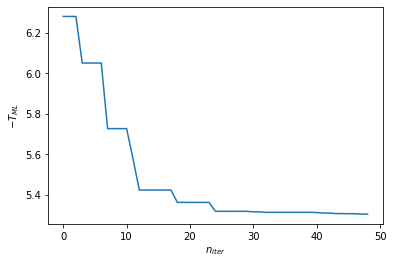

In [184]:
plt.ylabel("$-T_{ML}$")
plt.xlabel("$n_{iter}$")
plt.plot(progress_val)

### Randomness method

In [11]:
num_qubits = 2
from matplotlib import pyplot as plt
# psi = 2*np.random.rand(2**num_qubits)-1
# psi = psi / np.linalg.norm(psi)
# qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
# qc.initialize(psi, range(0, num_qubits))
# state = qiskit.quantum_info.Statevector(qc).data
# state = np.real(state.reshape((2**num_qubits, 1)))
state = tqix.random(4)
max_tml = 0
tmls = []
iterations = 0
fidelities = []
for i in range(0, 10000000):
    # trial_state = np.random.uniform(low = 0, high = 2*np.pi, size = (2**num_qubits, 1))
    # trial_state = trial_state / np.linalg.norm(trial_state)
    trial_state = tqix.random(4)
    tml = calculate_TML(state, trial_state)
    tmls.append(tml)
    if i == 0 or max_tml < tml:
        max_tml = tml
        reconstructed_state = trial_state
        iterations += 1
        if iterations % 10 == 0:
            print(iterations)

        # if fidelity > 0.99:
        #     print('Founded')
        #     break
        if tml >= 1 or iterations == 400:
            break
        state1 = np.squeeze(state, axis = 1)
        reconstructed_state1 = np.squeeze(reconstructed_state, axis = 1)
        trace, fidelity = .get_metrics(state1, reconstructed_state1)
        fidelities.append(fidelity)
print(tml)
print("State: ", state)
print("Reconstructed state: ", reconstructed_state)
plt.plot(fidelity)



10


first, we change ghz(1) by Haar random called from Qiskit. let fix N = 2.
then we calculate the cdf_model probabilites so, now we have f_r.

len(f_r) = (2^n + 1)*2^n
f_r(1) = (2^1 + 1)*2
Next, we calculate the trial probabilities, to calculate the trial probabilities, you can call the probability from model (not cdf_model)

1. We have $f_r$ based on measure random unknown state
2. For each $|\psi_{trial}\rangle$, we have different $P_r$.
3. And $T_{ML}(\psi_{trial})=\Sigma (f_r.\log(P_R)) \in C$?

We repeat 2-3 until $T_{ML}(\psi_{trial})$ max and $\psi_{trial}$ is $|\mu\rangle$

<img width = 500px src = '../../images/classical_tomography.jpg'/>